In [16]:
# Downloads dataset
!wget -nv https://data.mendeley.com/public-files/datasets/bbmmm4wgr8/files/3516f33e-d439-493d-b94c-8121e6f5884c/file_downloaded -O data.csv -nc

In [17]:
# Data ingestion
import pandas as pd

# Dropping path since we won't use the images, and public_id since it's not useful
df = pd.read_csv("data.csv").drop(columns=["path", "public_id"])
df.rename(
    columns={"TaskII": "TaskI", "TaskIII": "TaskII", "TaskIV": "TaskIII"}, inplace=True
)
df.head()

# My enroll id ends with `4`, so I'm assigned to TaskII
tasks = set(["TaskI", "TaskII", "TaskIII"])
assigned_task = "TaskII"
remaining_tasks = tasks - set([assigned_task])

# Other tasks must be ignored
df = df.drop(columns=remaining_tasks)

In [18]:
# Data proprocessing
# Converting string labels to numerical
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
nominal_columns = df.select_dtypes(include=["object"]).columns
for col in nominal_columns:
    df[col] = encoder.fit_transform(df[col])

# Normalizing numerical data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_columns = df.select_dtypes(include=["float64"]).columns
for col in numerical_columns:
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

# Splitting data into features and target
X, y = df.drop(columns=assigned_task), df[assigned_task]

df.head()

,lesion_id,patient_id,localization,larger_size,tobacco_use,alcohol_consumption,sun_exposure,gender,skin_color,age_group,diagnosis,dysplasia_severity,TaskII
0,50,48,5,0.245706,3,1,0,1,0,2,2,3,1
1,50,48,5,0.245706,3,1,0,1,0,2,2,3,1
2,41,39,5,0.594820,3,0,2,1,3,1,2,3,1
3,41,39,5,0.594820,3,0,2,1,3,1,2,3,1
4,87,81,3,-0.103408,0,3,2,0,3,2,2,3,1


A primeira etapa consiste no treino e teste com 3 rodadas de validação cruzada estratificada de 10 folds do classificador que não possui hiperparâmetros, isto é, os classificadores ZR e NB.

In [19]:
# Split the data into training and test sets
from sklearn.model_selection import (
    cross_val_score,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from scipy import stats
import numpy as np


# Random state value set assignment specification
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)


def scores(model) -> dict[str, float]:
    scorings = "accuracy"
    scores = cross_val_score(model, X, y, scoring=scorings, cv=rkf, n_jobs=-1)
    scores_acc = scores
    scores_mean = scores_acc.mean()
    scores_std = scores_acc.std()
    inf, sup = stats.norm.interval(
        0.95, loc=scores_mean, scale=scores_std / np.sqrt(len(scores_acc))
    )
    return {
        "mean": scores_mean,
        "std": scores_std,
        "inf": inf if not np.isnan(inf) else 0.0,
        "sup": sup if not np.isnan(sup) else 0.0,
        "raw": scores_acc,
    }


def scores_gridsearch(model, param_grid) -> dict[str, float]:
    clf = GridSearchCV(
        estimator=model, param_grid=param_grid, scoring="accuracy", cv=rkf, n_jobs=-1
    )
    return scores(clf)

In [20]:
from sklearn.dummy import DummyClassifier

zeroR = DummyClassifier(strategy="most_frequent")
zeroR_scores = scores(zeroR)
print(f"ZeroR: {({key: value for key, value in zeroR_scores.items() if key != 'raw'})}")

ZeroR: {'mean': 0.7597826086956523, 'std': 0.014943181613986452, 'inf': 0.754435358089203, 'sup': 0.7651298593021015}


In [21]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes_scores = scores(naive_bayes)
print(f"Naive Bayes: {naive_bayes_scores}")

Naive Bayes: {'mean': 1.0, 'std': 0.0, 'inf': 0.0, 'sup': 0.0, 'raw': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}


/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


A segunda etapa consiste no treino, validação e teste dos classificadores que precisam de ajuste de hiperparâmetros, isto é, os classificadores DT, KNN, MLP, RF e HP. Neste caso o procedimento de treinamento, validação e teste será realizado através de 3 rodadas de ciclos aninhados de validação e teste, com o ciclo interno de validação contendo 4 folds e o externo de teste com 10 folds. A busca em grade (grid search) do ciclo interno deve considerar os seguintes valores de hiperparâmetros de cada técnica de aprendizado:
```
Decision Tree: {'criterion': ['gini','entropy'],
                'max_depth': range(1,10)}
K Vizinhos Mais Próximo: {‘n_neighbors’:[1,3,5,7,9]}
Support Vector Machine: {'hidden_layer_sizes': [(100,),(10,)],
                        'activation': ['relu'],
                        'solver': ['adam'],
                        'alpha': [0.0001, 0.05],
                        'learning_rate': ['constant','adaptive']}
Random Forest: {'n_estimators': [50, 100, 150],
                'max_depth': [5, 10, 15, None],
                'max_features': ['sqrt', 'log2', None]}
HeterogeneousPooling: {‘n_samples’: [1, 3, 5, 7]}
```

In [22]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=11)
decision_tree_scores = scores_gridsearch(
    decision_tree, {"max_depth": list(range(1, 10)), "criterion": ["gini", "entropy"]}
)
print(
    f"Decision Tree: {({key: value for key, value in decision_tree_scores.items() if key != 'raw'})}"
)

Decision Tree: {'mean': 1.0, 'std': 0.0, 'inf': 0.0, 'sup': 0.0}


/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs=-1)
knn_scores = scores_gridsearch(knn, {"n_neighbors": [1, 3, 5, 7, 9]})
print(
    f"K-Nearest Neighbors: {({key: value for key, value in knn_scores.items() if key != 'raw'})}"
)

K-Nearest Neighbors: {'mean': 0.9943236714975845, 'std': 0.02124402657956059, 'inf': 0.9867217339085602, 'sup': 1.0019256090866089}


In [24]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=11)
mlp_scores = scores_gridsearch(
    mlp,
    {
        "hidden_layer_sizes": [(100,), (10,)],
        "activation": ["relu"],
        "solver": ["adam"],
        "alpha": [0.0001, 0.05],
        "learning_rate": ["constant", "adaptive"],
    },
)
print(
    f"Multi-layer Perceptron: {({key: value for key, value in mlp_scores.items() if key != 'raw'})}"
)

/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron

Multi-layer Perceptron: {'mean': 0.9060990338164251, 'std': 0.08218741014011768, 'inf': 0.8766891872344293, 'sup': 0.9355088803984208}


/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=11, n_jobs=-1)
rf_scores = scores_gridsearch(
    rf,
    {
        "n_estimators": [50, 100, 150],
        "max_depth": [5, 10, 15, None],
        "max_features": ["sqrt", "log2", None],
    },
)
print(
    f"Random Forest: {({key: value for key, value in rf_scores.items() if key != 'raw'})}"
)

Random Forest: {'mean': 1.0, 'std': 0.0, 'inf': 0.0, 'sup': 0.0}


/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


O classificador Heterogeneous Pooling é um combinado de classificadores heterogêneos que usa como classificadores base: Árvore de Decisão (DT), Naive Bayes Gaussiano (NB) e K Vizinhos Mais Proximo (KNN), sempre com valores default do sklearn para seus hiperparâmetros. O único parâmetro do método Heterogeneous Pooling é o n_samples, que indica o número de vezes que os classificadores base serão usados para gerar o combinado. Por exemplo, se n_samples é igual a 3, o combinado será composto por 9 classificadores: 3 árvores de decisão, 3 naive bayes e 3 vizinhos mais próximos. Para diferenciar os classificadores de mesmo tipo em um combinado, o primeiro deles será treinado com a base de treino original e os demais serão treinados com uma base de treino diferente, obtida a partir da base de treino original através de um método para seleção de características. O método consiste em selecionar aleatoriamente um número de características, variando de 2 até o (número de características - 1) e, a partir desse número, devem ser selecionadas as N características através de uma roleta onde a chance de uma característica ser escolhida é baseada no seu [ANOVA F-value](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html). **Atenção, uma característica não deve ser escolhida mais de uma vez.** Assim, toda vez que uma característica é selecionada a roleta deve redistribuir as chances das demais características 
O critério de decisão para classificar uma instância é a votação majoritária, ou seja, deve-se escolher a classe mais escolhida dentre os classificadores que compõem o combinado. Em caso de empate, a classe escolhida deve ser a mais frequente na base de dados de treino original dentre as que empataram na votação.

O pseudo código a seguir mostra como o HP é obtido a partir de uma base de dados de treino:
```pseudo
- Obter e armazenar a ordenação das classes de acordo com a ocorrência nos exemplos na
base de treino (ordenar decrescentemente da mais frequente para a menos frequente)
- Para cada um dos `n_samples` faça
    - Se for a primeira iteração então
        - Usar a base original para treino dos classificadores
    - Senão
        - Escolher o número de características aleatoriamente (2 a n_caracteristicas-1)
        - Montar a base selecionando as características utilizando o método da roleta.
    - Fim-se
    - Treinar os classificadores KNN, NB, DT na base de treino corrente e incluí-los no combinado de classificadores
- Fim-para
```

O pseudo código seguinte mostra como o combinado HP é usado para classificar um exemplo
da base de dados de teste:
```pseudo
- Para cada um dos classificadores individuais do combinado faça
    - Obter a classificação do exemplo usando o classificador individual e armazenar a classe selecionada
- Fim-para
- Contar quantas vezes cada classe foi selecionada e obter a(s) mais votada(s)
- Se mais de uma classe for a mais votada então
    - Retornar a classe mais votada mais frequente na base de treino dentre as que empataram
- Senão
    - Retornar a classe mais votada
- Fim-se
```

In [ ]:
from sklearn.ensemble import VotingClassifier


class HeterogenousPooling(VotingClassifier):
    estimators_ = [
        GaussianNB(),
        DecisionTreeClassifier(),
        KNeighborsClassifier(n_jobs=-1),
    ]

    def __init__(self):
        super().__init__(n_jobs=-1)

    def fit(self, X, y, sample_weight=None):
        # TODO attribute dropping shananigan
        super()._raise_for_unsupported_routing(self, "fit", sample_weight=sample_weight)
        y_type = super().type_of_target(y, input_name="y")
        if y_type in ("unknown", "continuous"):
            # raise a specific ValueError for non-classification tasks
            raise ValueError(
                f"Unknown label type: {y_type}. Maybe you are trying to fit a "
                "classifier, which expects discrete classes on a "
                "regression target with continuous values."
            )
        elif y_type not in ("binary", "multiclass"):
            # raise a NotImplementedError for backward compatibility for non-supported
            # classification tasks
            raise NotImplementedError(
                f"{self.__class__.__name__} only supports binary or multiclass "
                "classification. Multilabel and multi-output classification are not "
                "supported."
            )

        self.le_ = super().LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        transformed_y = self.le_.transform(y)

        return super().fit(X, transformed_y, sample_weight)

    def predict(self, X):
        super().check_is_fitted(self)
        if self.voting == "soft":
            maj = np.argmax(self.predict_proba(X), axis=1)

        else:  # 'hard' voting
            predictions = self._predict(X)
            maj = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self._weights_not_none)),
                axis=1,
                arr=predictions,
            )

        maj = self.le_.inverse_transform(maj)

        return maj

Os resultados de cada classificador devem ser apresentados numa tabela contendo a média das acurácias obtidas em cada fold, o desvio padrão e o intervalo de confiança a 95% de significância dos resultados, e também através do boxplot dos resultados de cada classificador em cada fold.

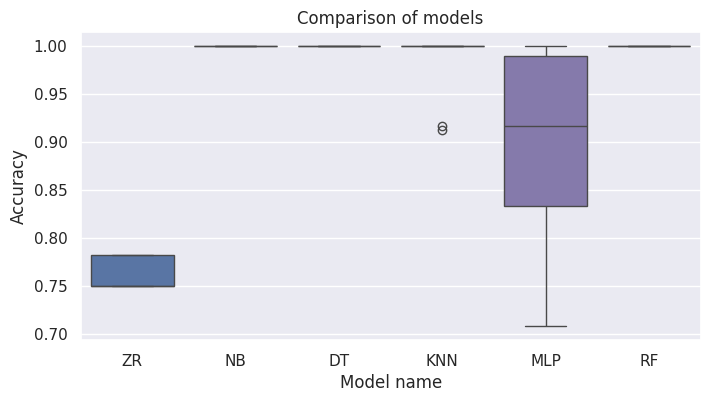

In [26]:
# Boxplot a comparison between all models
import matplotlib.pyplot as plt
import seaborn as sns

agg_data = {
    "ZR": zeroR_scores,
    "NB": naive_bayes_scores,
    "DT": decision_tree_scores,
    "KNN": knn_scores,
    "MLP": mlp_scores,
    "RF": rf_scores,
}

sns.set(rc={"figure.figsize": (8, 4)})
fig, ax = plt.subplots()
ax.set_xlabel("Model name")
sns.boxplot(data={k: v["raw"] for k, v in agg_data.items()})
plt.ylabel("Accuracy")
plt.title("Comparison of models")
plt.show()

In [68]:
get_stat = lambda stat_name: [
    model_stats[stat_name] for model_name, model_stats in agg_data.items()
]

table = pd.DataFrame(
    {
        "Média": get_stat("mean"),
        "Desvio Padrão": get_stat("std"),
        "Limite Inferior": get_stat("inf"),
        "Limite Superior": get_stat("sup"),
    },
    index=pd.Index(agg_data.keys(), name="Método"),
)
pd.set_option("display.precision", 2)

table

,Média,Desvio Padrão,Limite Inferior,Limite Superior
Método,,,,
ZR,0.76,0.01,0.75,0.77
NB,1.00,0.00,0.00,0.00
DT,1.00,0.00,0.00,0.00
KNN,0.99,0.02,0.99,1.00
MLP,0.91,0.08,0.88,0.94
RF,1.00,0.00,0.00,0.00


Além das tabelas e dos gráficos bloxplot, será necessário apresentar também a tabela pareada dos resultados (p-values) dos testes de hipótese entre os pares de métodos. Na matriz triangular superior devem ser apresentados os resultados do **teste t pareado <u>corrigido</u>** (amostras dependentes) e na matriz triangular inferior devem ser apresentados os resultados do **teste não paramétrico de Wilcoxon**. Os valores da célula da tabela que rejeitarem a hipótese nula para um nível de significância de 95% devem ser escritos em negrito.

In [75]:
from scipy.stats import wilcoxon, ttest_rel

table_raw_stats = {key: value["raw"] for key, value in agg_data.items()}

model_pairs = set(
    [
        frozenset({model1, model2})
        for model1 in agg_data.keys()
        for model2 in agg_data.keys()
        if model1 != model2
        # TODO Doing a dirty blacklist to avoid some comparisons for now
        and frozenset({model1, model2})
        not in (
            frozenset({"NB", "RF"}),
            frozenset({"NB", "DT"}),
            frozenset({"NB", "KNN"}),
            frozenset({"RF", "DT"}),
            frozenset({"RF", "KNN"}),
            frozenset({"MLP", "KNN"}),
            frozenset({"ZR", "NB"}),
            frozenset({"ZR", "DT"}),
        )
    ]
)


def hipothesis_tests(pair: frozenset[str]) -> tuple[float, float]:
    model_name1, model_name2 = pair
    dataset1 = table_raw_stats[model_name1]
    dataset2 = table_raw_stats[model_name2]
    # print(f"{model_name1} vs {model_name2}")
    return (
        ttest_rel(dataset1, dataset2),
        wilcoxon(dataset1, dataset2),
    )


table_stats = {pair: hipothesis_tests(pair) for pair in model_pairs}

model_order = list(agg_data.keys())


def table_stat(model1_name: str, model2_name: str):
    keys = list(agg_data.keys())
    if keys.index(model1_name) < keys.index(model2_name):  # lower triangle
        return table_stats[frozenset({model1_name, model2_name})][1].pvalue
    # upper triangle
    return table_stats[frozenset({model1_name, model2_name})][0].pvalue


table = [
    (
        model_name1
        if model_name1 == model_name2  # diagonal
        else (
            "Not tested"
            if frozenset({model_name1, model_name2})
            not in table_stats  # not tested, all zeroes
            else f"{table_stat(model_name1, model_name2):.4f}"
        )
    )
    for model_name1 in agg_data.keys()
    for model_name2 in agg_data.keys()
]

table = pd.DataFrame(
    np.array(table).reshape(len(agg_data), len(agg_data)), index=None, columns=None
)
table

,0,1,2,3,4,5
0,ZR,Not tested,Not tested,0.0000,0.0000,0.0000
1,Not tested,NB,Not tested,Not tested,0.0000,Not tested
2,Not tested,Not tested,DT,0.1797,0.0000,Not tested
3,0.0000,Not tested,0.1609,KNN,Not tested,Not tested
4,0.0000,0.0000,0.0000,Not tested,MLP,0.0000
5,0.0000,Not tested,Not tested,Not tested,0.0000,RF
